# Get DHV XC Data

In [2]:
import requests
import urllib
import pandas as pd

PAGE_SIZE = 500

places = {
    'Metzingen':11185,
    'Rammelsberg': 9427,
    'Estorf': 11001,
    'Leese': 10746,
    'Porta': 9712,
    'Lüdingen':9759,
    'Brunsberg': 9844,
    'Kella': 9521,
    'Börry': 9403
}

results = []
for place in ['Metzingen','Estorf','Leese','Lüdingen']:
    limit = PAGE_SIZE
    for year in [2017,2018,2019,2020,2023,2024]:
        query = {"navpars":{"start":0,"limit":PAGE_SIZE,"sort":[{"field":"FlightDate","dir":-1},{"field":"BestTaskPoints","dir":-1}]}}
        # for some reason, " is replaced by ' and spaces are added which is replaced by +
        decoded_url = f"https://de.dhv-xc.de/api/fli/flights?y={year}&fkcat%5B%5D=1&fkto%5B%5D={places[place]}&{urllib.parse.urlencode(query,quote_via=urllib.parse.quote_plus).replace('%27', '%22').replace('+', '')}"
        #print(decoded_url)
        r = requests.get(decoded_url)
        if r.status_code==200:
            response = r.json()
            df0 = pd.DataFrame(response['data'])
            #print(df.columns.values)
            results.extend(df0[['FlightDate', 'TakeoffWaypointName' , 'Glider' ,'FlightDuration']].values)


df_results = pd.DataFrame(results,columns=['FlightDate','Takeoff', 'Glider' ,'Duration'])
df_results = df_results.astype(dtype= {"Duration":"int64"})
print(len(df_results))
df_results.sort_values(by='Duration').tail()

4178


,FlightDate,Takeoff,Glider,Duration
3405,2019-06-09,Lüdingen,Zeno - S [LTF D],23778
2772,2017-05-20,Lüdingen,Base - L [LTF B],23816
2703,2017-06-19,Lüdingen,Mantra M6,24111
3423,2019-05-18,Lüdingen,MantraM7 - MS [LTF D],26553
3447,2019-05-14,Lüdingen,Cayenne5 - XS [LTF C],27315


In [3]:
from datetime import datetime

dhv_aggr = df_results.groupby('FlightDate')['Duration'].agg(['count','sum']).reset_index()

dhv_aggr = dhv_aggr.merge(df_results[df_results['Takeoff']=='Metzingen'].groupby('FlightDate')['Duration'].agg('count').reset_index(), on='FlightDate', how='left').fillna(0)

dhv_aggr.rename(columns={'FlightDate':'time','Duration':'count_M'},inplace=True)

print(len(dhv_aggr))

dhv_aggr.head()

322


,time,count,sum,count_M
0,2017-01-06,4,2470,0.0
1,2017-01-28,16,6069,8.0
2,2017-02-15,14,6272,0.0
3,2017-03-11,12,7001,2.0
4,2017-03-16,13,8906,0.0


# Get OpenMeteo Data

In [7]:
import requests
import pandas as pd
from datetime import timedelta

LOCATIONS = {
    'Metzingen' : {'lat':52.67057, 'long':10.37136},
    'Hannover Station 2014':  {'lat':52.4644, 'long':9.6779}
    }


DAILY = [
  'sunshine_duration',
  'rain_sum',
  'wind_speed_10m_max',
  'wind_gusts_10m_max',
  'wind_direction_10m_dominant',
  'temperature_2m_mean',
  'precipitation_hours'
]


dates = [
      {'StartDate': '2017-01-01', 'EndDate': '2018-12-31'},
      {'StartDate': '2019-01-01', 'EndDate': '2020-12-31'},
      {'StartDate': '2023-01-01', 'EndDate': '2024-11-24'}
]

loc = 'Metzingen'

dfs = []
for date in dates:
  url = f'https://archive-api.open-meteo.com/v1/archive?latitude={LOCATIONS[loc]["lat"]}&longitude={LOCATIONS[loc]["long"]}&start_date={date["StartDate"]}&end_date={date["EndDate"]}&daily={",".join(DAILY)}&timezone=GMT'
  #print(url)
  res = requests.get(url)
  if res.status_code == 200:
    data = res.json()
    dfs.append(pd.DataFrame(data['daily'], columns= data['daily_units']))


df = pd.concat(dfs)
df['Weekday'] = df.apply(lambda row:datetime.strftime(datetime.strptime(row['time'],'%Y-%m-%d'),'%a'), axis=1)
df['prev_time'] = df.apply(lambda row:datetime.strftime(datetime.strptime(row['time'],'%Y-%m-%d')-timedelta(days=1),'%Y-%m-%d'), axis=1)

df.rename(columns={
    'sunshine_duration':'sun',
    'rain_sum':'rain',
    'wind_speed_10m_max':'wind',
    'wind_gusts_10m_max':'gust',
    'wind_direction_10m_dominant':'dir',
    'temperature_2m_mean': 'temp',
    'precipitation_hours': 'rain_dur'
    },inplace=True)


df_prev= df[['time','sun','rain','wind','gust','dir','rain_dur','temp']].copy(deep=True)

df_prev.rename(columns={k:'prev_'+k for k in ['time','sun','rain','wind','gust','dir','rain_dur','temp']} ,inplace=True)

df = df.merge(df_prev, on='prev_time',how='left')

df.head()

,time,sun,rain,wind,gust,dir,temp,rain_dur,Weekday,prev_time,prev_sun,prev_rain,prev_wind,prev_gust,prev_dir,prev_rain_dur,prev_temp
0,2017-01-01,0.00,0.2,17.4,34.2,235,1.2,6.0,Sun,2016-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-02,14223.38,0.4,19.2,37.1,272,0.9,11.0,Mon,2017-01-01,0.00,0.2,17.4,34.2,235.0,6.0,1.2
2,2017-01-03,0.00,6.9,34.5,68.0,256,2.2,16.0,Tue,2017-01-02,14223.38,0.4,19.2,37.1,272.0,11.0,0.9
3,2017-01-04,12665.65,7.6,33.8,80.3,296,2.4,16.0,Wed,2017-01-03,0.00,6.9,34.5,68.0,256.0,16.0,2.2
4,2017-01-05,22850.84,0.0,18.3,41.0,2,-3.8,1.0,Thu,2017-01-04,12665.65,7.6,33.8,80.3,296.0,16.0,2.4


# Merge flight and weather data

In [8]:
dfm = df.merge(dhv_aggr, on='time', how='left').fillna(0)
filter = (dfm['Weekday'].isin(['Sat','Sun'])) | (dfm['count'] > 0) # ???

dfm=dfm[filter]

# true ratios
filters = [
    ((dfm['time'] > '2022-12-31') & (dfm['Weekday'].isin(['Sat','Sun']))),
    (dfm['time'] > '2022-12-31'),
    (dfm['time'] > '2018-12-31')  & (dfm['Weekday'].isin(['Sat','Sun'])),
    (dfm['time'] > '2018-12-31'),
    (dfm['Weekday'].isin(['Sat','Sun'])),
    (dfm['time'] > '2016-12-31'),
    ]
for filter in filters:
    print(f"Metzingen: {len(dfm[filter & (dfm['count_M']>0)])/len(dfm[filter]):.4f}, others: {len(dfm[filter & (dfm['count']>0)])/len(dfm[filter]):.4f}")

dfm.head()

Metzingen: 0.1508, others: 0.2362
Metzingen: 0.1913, others: 0.3391
Metzingen: 0.1278, others: 0.2432
Metzingen: 0.1606, others: 0.3740
Metzingen: 0.1461, others: 0.2711
Metzingen: 0.1688, others: 0.4169


,time,sun,rain,wind,gust,dir,temp,rain_dur,Weekday,prev_time,prev_sun,prev_rain,prev_wind,prev_gust,prev_dir,prev_rain_dur,prev_temp,count,sum,count_M
0,2017-01-01,0.00,0.2,17.4,34.2,235,1.2,6.0,Sun,2016-12-31,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2017-01-06,22971.76,0.0,11.0,19.8,201,-6.7,0.0,Fri,2017-01-05,22850.84,0.0,18.3,41.0,2.0,1.0,-3.8,4.0,2470.0,0.0
6,2017-01-07,0.00,0.4,19.1,39.2,235,-3.3,9.0,Sat,2017-01-06,22971.76,0.0,11.0,19.8,201.0,0.0,-6.7,0.0,0.0,0.0
7,2017-01-08,0.00,0.1,12.3,22.3,305,0.3,1.0,Sun,2017-01-07,0.00,0.4,19.1,39.2,235.0,9.0,-3.3,0.0,0.0,0.0
13,2017-01-14,20642.83,0.6,22.0,48.6,281,0.5,7.0,Sat,2017-01-13,2830.21,2.5,26.0,51.8,256.0,16.0,0.6,0.0,0.0,0.0


# Use floor-log-scale for the count

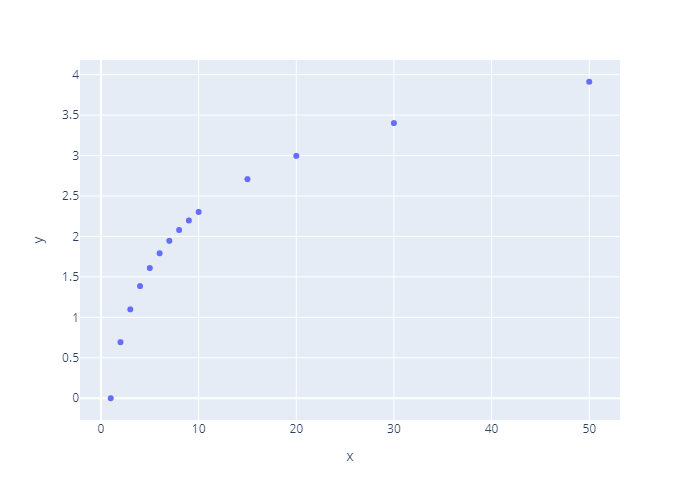

In [11]:
import plotly.express as px 
import numpy as np

X=[1,2,3,4,5,6,7,8,9,10,15,20,30,50]
fig= px.scatter(x=X,y=[np.log(x) for x in X])
fig.show('png')


# Training

In [47]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
import numpy as np

features = ['wind','sun','gust','rain']
#features = features + ['prev_'+k for  k in features]
#features = ['prev_'+k for  k in features]


train_filter = (dfm['time'] < '2024-01-01')


xtrain = dfm[train_filter][features].to_numpy()
# Apply LOG (?and FLOOR) to have fewer "categories"
ytrain = [np.log(y) if y > 0 else 0 for y in dfm[train_filter]['count'].to_numpy()]


regr = RandomForestRegressor(random_state=0,n_estimators=200)
regr.fit(xtrain,ytrain)

print({k:regr.feature_importances_[j] for j,k in enumerate(features)} )

ypred = regr.predict(xtrain)
print(((ytrain-ypred)**2).mean())
for thr in [0.,0.5,1.,1.5,2.]:
    tp = len([1 for j in range(len(ytrain)) if ytrain[j] > 0 and ypred[j] >= thr])
    fp = len([1 for j in range(len(ytrain)) if ytrain[j] == 0 and ypred[j] >= thr])
    fn = len([1 for j in range(len(ytrain)) if ytrain[j] > 0 and ypred[j] < thr])
    prec, rec = tp/(tp+fp) , tp/(tp+fn)
    f1score = 2.0*prec*rec/(prec+rec)
    print(f'threshold: {thr:.4f}, {prec:.4f}, {rec:.4f}, f1-score: {f1score:.4f}')

{'prev_wind': 0.23898321247671667, 'prev_sun': 0.41276065089688907, 'prev_gust': 0.20844422910247834, 'prev_rain': 0.13981190752391584}
0.20154804718597966
threshold: 0.0000, 0.3997, 1.0000, f1-score: 0.5711
threshold: 0.5000, 0.7909, 0.9924, f1-score: 0.8803
threshold: 1.0000, 0.9960, 0.9468, f1-score: 0.9708
threshold: 1.5000, 1.0000, 0.7719, f1-score: 0.8712
threshold: 2.0000, 1.0000, 0.4563, f1-score: 0.6266


# Test / evaluate

In [48]:
df_test = dfm[~train_filter].copy(deep=True)
xtest =df_test[features].to_numpy()
ytest =  [np.log(y) if y > 0 else 0 for y in df_test['count'].to_numpy()]

ypred = regr.predict(xtest)
print(((ytest-ypred)**2).mean())

thr = 1.0
tp = len([1 for j in range(len(ytest)) if ytest[j] > 0 and ypred[j] >= thr])
fp = len([1 for j in range(len(ytest)) if ytest[j] == 0 and ypred[j] >= thr])
fn = len([1 for j in range(len(ytest)) if ytest[j] > 0 and ypred[j] < thr])
prec, rec = tp/(tp+fp) , tp/(tp+fn)
f1score = 2.0*prec*rec/(prec+rec)
print(f'threshold: {thr:.4f}, {prec:.4f}, {rec:.4f}, f1-score: {f1score:.4f}')

df_test['pred'] = df_test.apply(lambda row: np.exp(regr.predict([row[features]])[0]),axis=1)

print(df_test[(df_test['count'] > 0)|(df_test['pred'] > np.exp(thr))][['time','count_M','count','pred']+features].to_markdown())

1.483499980793567
threshold: 1.0000, 0.5217, 0.5714, f1-score: 0.5455
|      | time       |   count_M |   count |     pred |   prev_wind |   prev_sun |   prev_gust |   prev_rain |
|-----:|:-----------|----------:|--------:|---------:|------------:|-----------:|------------:|------------:|
| 1845 | 2024-01-20 |         0 |       0 |  3.50237 |        26.1 |   24971    |        50.4 |         0   |
| 1853 | 2024-01-28 |         0 |       2 |  2.09312 |        20.2 |   25915.8  |        41.4 |         0   |
| 1874 | 2024-02-18 |         0 |       0 |  5.68951 |        19.4 |   17856.4  |        41.4 |         0.2 |
| 1881 | 2024-02-25 |         0 |       0 |  3.60694 |        22.1 |   32571.7  |        44.6 |         0.4 |
| 1887 | 2024-03-02 |         0 |       0 |  4.40334 |        14.2 |   26537.9  |        31   |         0   |
| 1894 | 2024-03-09 |         0 |       0 |  4.08028 |        19.6 |   36947.1  |        41.8 |         0   |
| 1902 | 2024-03-17 |         0 |      10 |  1.585